In [ ]:
! pip install -q -U tensorflow-io transformers librosa tensorflow==2.11.0 tf2onnx keras2onnx onnxruntime

# importing Dependencies

In [ ]:
import warnings
import pandas as pd 
warnings.filterwarnings('ignore')
import os
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import numpy as np
import librosa
device_name = tf.test.gpu_device_name()
device_name
import keras
import tf2onnx
import onnx
import onnxruntime as ort

# Set up file location

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
audio_path = '/content/drive/MyDrive/Pattern_Recognition/augmented-audio'

In [ ]:
for i in os.listdir(audio_path):
  print(i)

Brene Brown
Simon Sinek
Les Brown
Nick Vujicic
Jay Shetty
Eric Thomas
Eckhart Tolle
Oprah Winfrey
Rabin Sharma
Gary Vee
Mel Robbins


# Set up Hyper parameters 

Here num_classes are number of speakers.

Num_samples = 80000 is sample rate, as audios length are 5s so sample rate for 5s is 80000.

I kept Batch_size is 32, and learning_rate = 0.001

In [ ]:
num_classes = 11
num_samples = 80000
num_mel_bins = 128
fft_length = 2048
hop_length = 512
batch_size = 32
learning_rate = 0.001

# Make a list data with labels

In [ ]:
audio_files = []
labels = []

labelind = -1
for label in os.listdir(audio_path):
    labelind +=1
    label_path = os.path.join(audio_path, label)
    for audio_file in os.listdir(label_path):
        audio_file_path = os.path.join(label_path, audio_file)
        audio_files.append(audio_file_path)
        labels.append(labelind)

# Preprocess audio file into numeric form

In [ ]:

def preprocess_audio(audio_file_path):
    audio, sr = librosa.load(audio_file_path, sr=num_samples)
    if len(audio) > num_samples:
        audio = audio[:num_samples]
    else:
        audio = np.pad(audio, (0, num_samples - len(audio)), 'constant')
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=fft_length, hop_length=hop_length, n_mels=num_mel_bins)
    mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
    return abs(mel_spec_db)

audio_data = []

for audio_file in audio_files:
    mel_spec_db = preprocess_audio(audio_file)
    audio_data.append(mel_spec_db)

audio_data = np.array(audio_data)
labels = np.array(labels)

# Spliting main data into Train and Test data

In [ ]:

num_examples = len(audio_files)
num_train_examples = int(num_examples * 0.8)
num_val_examples = num_examples - num_train_examples

train_indices = np.random.choice(num_examples, num_train_examples, replace=False)
val_indices = np.array(list(set(range(num_examples)) - set(train_indices)))

train_data = audio_data[train_indices]
train_labels = labels[train_indices]

val_data = audio_data[val_indices]
val_labels = labels[val_indices]

In [ ]:
# Create TensorFlow datasets for the training and validation sets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=num_train_examples)
train_dataset =train_dataset.batch(batch_size=batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels))
val_dataset = val_dataset.batch(batch_size=batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

# Simple Model

In [ ]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(128, 157, 1)), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(32, (3, 3)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(128, (3, 3)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)), 
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(256, (3, 3)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),
        
    
    tf.keras.layers.GlobalAveragePooling2D(), 
    
    tf.keras.layers.Dense(256, activation='relu'),  
    tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(64, activation='relu'),   
#     tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(11, activation='softmax')
])

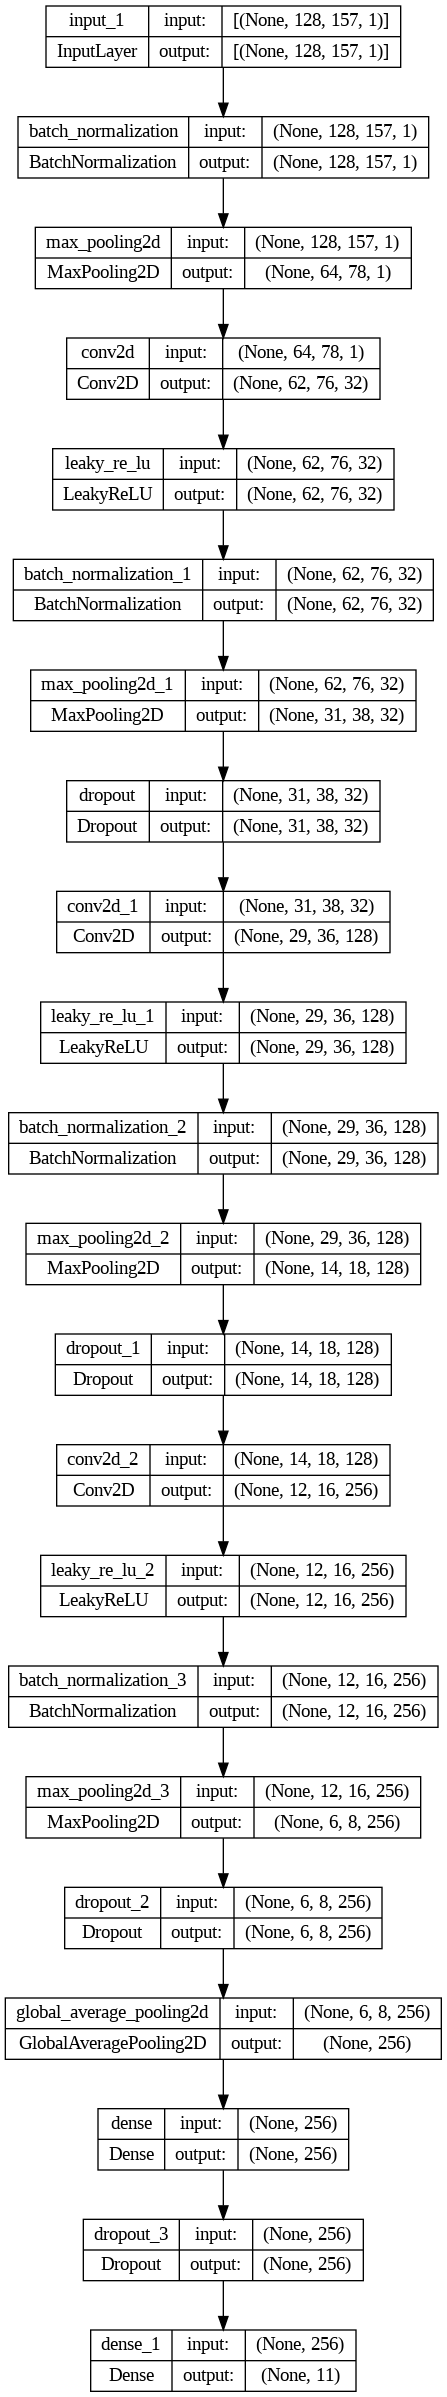

In [ ]:

from keras.utils.vis_utils import plot_model
plot_model(model2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Creating Callbacks for save the best trained model.

In [ ]:
call_back = [tf.keras.callbacks.ModelCheckpoint(filepath='best_model_vgg.h5', 
                                                monitor='val_accuracy',
                                                mode='max',
                                                verbose=1,
                                                save_best_only=True)]

In [ ]:
# Compile the model
model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',tf.keras.metrics.SparseCategoricalAccuracy()],
            
)

In [ ]:
hist = model2.fit(train_dataset, epochs=50, validation_data=val_dataset,callbacks=call_back)

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 2.1482 - accuracy: 0.2632 - sparse_categorical_accuracy: 0.2632
Epoch 1: val_accuracy improved from -inf to 0.10833, saving model to best_model_vgg.h5
195/195 [==============================] - 216s 1s/step - loss: 2.1482 - accuracy: 0.2632 - sparse_categorical_accuracy: 0.2632 - val_loss: 2.5867 - val_accuracy: 0.1083 - val_sparse_categorical_accuracy: 0.1083
Epoch 2/50
195/195 [==============================] - ETA: 0s - loss: 1.6610 - accuracy: 0.4296 - sparse_categorical_accuracy: 0.4296
Epoch 2: val_accuracy improved from 0.10833 to 0.37885, saving model to best_model_vgg.h5
195/195 [==============================] - 212s 1s/step - loss: 1.6610 - accuracy: 0.4296 - sparse_categorical_accuracy: 0.4296 - val_loss: 1.8440 - val_accuracy: 0.3788 - val_sparse_categorical_accuracy: 0.3788
Epoch 3/50
195/195 [==============================] - ETA: 0s - loss: 1.4056 - accuracy: 0.5188 - sparse_categorical_accuracy: 0.51

dict_keys(['loss', 'accuracy', 'sparse_categorical_accuracy', 'val_loss', 'val_accuracy', 'val_sparse_categorical_accuracy'])


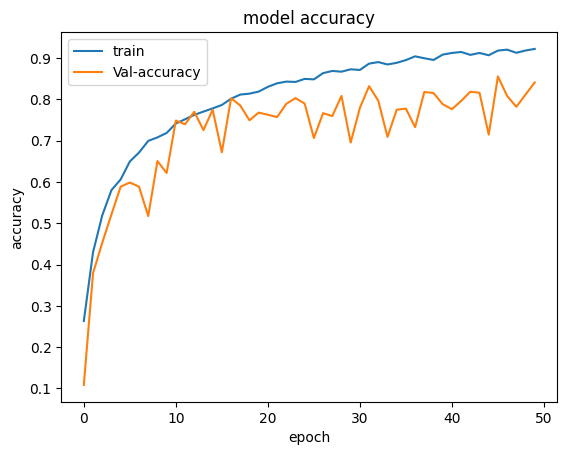

In [ ]:
print(hist.history.keys())
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
# plt.plot(hist.history['sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Val-accuracy'], loc='upper left')
plt.show()

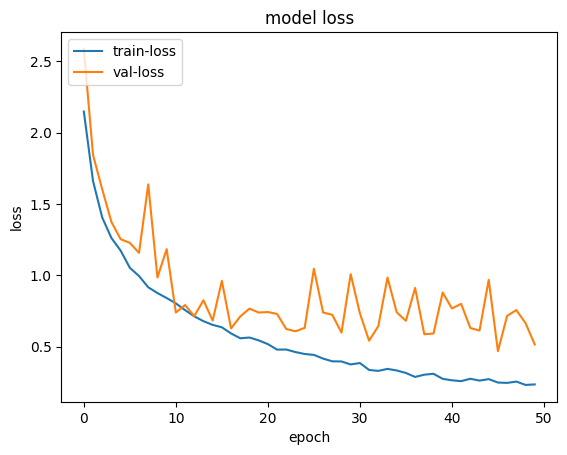

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train-loss', 'val-loss'], loc='upper left')
plt.show()

In [ ]:
features, labels = val_dataset.as_numpy_iterator().next()

In [ ]:
features[0]

array([[80.      , 73.65613 , 72.66452 , ..., 74.4775  , 71.362686,
        50.2431  ],
       [80.      , 73.866104, 75.701035, ..., 74.7296  , 61.31257 ,
        46.898144],
       [80.      , 80.      , 80.      , ..., 63.31755 , 59.130344,
        38.575832],
       ...,
       [80.      , 80.      , 80.      , ..., 80.      , 80.      ,
        80.      ],
       [80.      , 80.      , 80.      , ..., 80.      , 80.      ,
        80.      ],
       [80.      , 80.      , 80.      , ..., 80.      , 80.      ,
        80.      ]], dtype=float32)

In [ ]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
y_pred = model2.predict(features)

1/1 [==============================] - 1s 544ms/step


In [ ]:
pred = []

In [ ]:
for i in y_pred:
    pred.append(i.argmax())

In [ ]:
print(np.array(labels),'\n',np.array(pred))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 
 [ 0  0  0  0  0  9  0  0  0  9  0  0  0  0  7  0  0  0  0 10  0  0  0  0
  0  5  5  3  0  3  0  0]


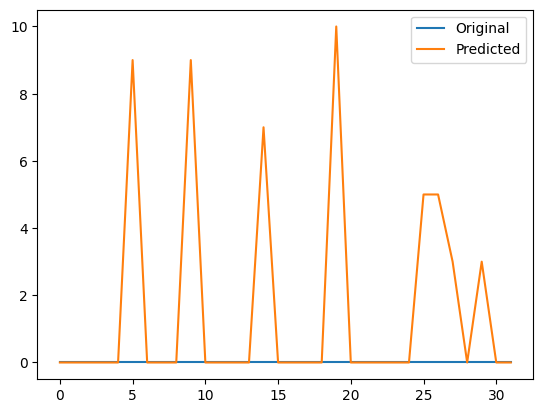

In [ ]:
plt.plot(np.array(labels),label = 'Original')
plt.plot(np.array(pred), label = 'Predicted')
plt.legend()
plt.show()

# Model size Compression using onnx

In [ ]:
model_path = 'best_model_vgg.h5'
keras_model = tf.keras.models.load_model(model_path)

In [ ]:
output_path = 'model_4.onnx'
onnx_model,_ = tf2onnx.convert.from_keras(keras_model)

In [ ]:
onnx.save_model(onnx_model, output_path)

In [ ]:
session = ort.InferenceSession(output_path)

# Checking everything is All right after size compression.

In [ ]:
audio = preprocess_audio('/content/drive/MyDrive/Pattern_Recognition/augmented-audio/Gary Vee/203Gary Vee36.wav')

FileNotFoundError: ignored

In [ ]:

audio = np.expand_dims(audio, axis=-1)
audio = np.expand_dims(audio, axis=0)

In [ ]:
np.argmax(model2.predict(audio))

In [ ]:

input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

output = session.run([output_name], {input_name:audio})

class_label = np.argmax(output)

In [ ]:
class_label